In [1]:
cd ..

/home/amir/projects/theis-lab/scarches


In [17]:
import torch
import numpy as np
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report
from sklearn.metrics.pairwise import cosine_similarity

from scarches.dataset.trvae.data_handling import remove_sparsity
from scarches.models.polie import PoLIE

sc.settings.set_figure_params(dpi=200, frameon=False)
sc.set_figure_params(dpi=500)
plt.rcParams['figure.figsize'] = (5, 5)
torch.set_printoptions(precision=3, sci_mode=False, edgeitems=7)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
PARAMS = {
    'EPOCHS': 100,                                     #TOTAL TRAINING EPOCHS
    'N_PRE_EPOCHS': 80,                                #EPOCHS OF PRETRAINING WITHOUT LANDMARK LOSS
    'DATA': 'pancreas',                                #DATA USED FOR THE EXPERIMENT
    'EARLY_STOPPING_KWARGS': {                         #KWARGS FOR EARLY STOPPING
        "early_stopping_metric": "val_landmark_loss",  ####value used for early stopping
        "mode": "min",                                 ####choose if look for min or max
        "threshold": 0,
        "patience": 20,
        "reduce_lr": True,
        "lr_patience": 13,
        "lr_factor": 0.1,
    },
    'LATENT_DIM': 25,
    'ALPHA_EPOCH_ANNEAL': 1e6,
    'CLUSTERING_RES': 2,
    'HIDDEN_LAYERS': 3,
    'ETA': 10,
}

condition_key = 'study'
cell_type_key = ['cell_type']
reference = ['inDrop1', 'inDrop2', 'inDrop3', 'inDrop4', 'fluidigmc1', 'smartseq2', 'smarter']
query = ['celseq', 'celseq2']

In [4]:
url = 'https://drive.google.com/uc?id=1ehxgfHTsMZXy6YzlFKGJOsBKQ5rrvMnd'
output = 'pancreas.h5ad'
gdown.download(url, output, quiet=False)

In [5]:
adata = sc.read("/home/amir/Downloads/pancreas.h5ad")
np.random.seed(0)
adata.obs['keep'] = np.random.choice([True, False], size=len(adata.obs), p=[0.05, 0.95])
adata = adata[adata.obs['keep']].copy()

In [6]:
adata.obs['query'] = adata.obs[condition_key].isin(query)
adata.obs['query'] = adata.obs['query'].astype('category')
source_adata = adata[adata.obs.study.isin(reference)].copy()
target_adata = adata[adata.obs.study.isin(query)].copy()

In [7]:
source_adata, target_adata

(AnnData object with n_obs × n_vars = 688 × 4000
     obs: 'study', 'cell_type', 'pred_label', 'pred_score', 'keep', 'query'
     obsm: 'X_seurat', 'X_symphony',
 AnnData object with n_obs × n_vars = 183 × 4000
     obs: 'study', 'cell_type', 'pred_label', 'pred_score', 'keep', 'query'
     obsm: 'X_seurat', 'X_symphony')

In [8]:
polie_model = PoLIE(
    adata=source_adata,
    condition_key=condition_key,
    cell_type_keys=cell_type_key,
    hidden_layer_sizes=[128]*int(PARAMS['HIDDEN_LAYERS']),
    latent_dim=PARAMS['LATENT_DIM'],
)

Embedding dictionary:
 	Num conditions: 7
 	Embedding dim: 10
Encoder Architecture:
	Input Layer in, out and cond: 4000 128 10
	Hidden Layer 1 in/out: 128 128
	Hidden Layer 2 in/out: 128 128
	Mean/Var Layer in/out: 128 25
Decoder Architecture:
	First Layer in, out and cond:  25 128 10
	Hidden Layer 1 in/out: 128 128
	Hidden Layer 2 in/out: 128 128
	Output Layer in/out:  128 4000 



In [9]:
polie_model.train(
    n_epochs=PARAMS['EPOCHS'],
    pretraining_epochs=PARAMS['N_PRE_EPOCHS'],
    early_stopping_kwargs=PARAMS['EARLY_STOPPING_KWARGS'],
    alpha_epoch_anneal=PARAMS['ALPHA_EPOCH_ANNEAL'],
    eta=PARAMS['ETA'],
    clustering_res=PARAMS['CLUSTERING_RES'],
    weight_decay=0
)

loaders init
loaders init done
0.0009551048278808594
 |████████████████████| 100.0%  - val_loss: 1068.0260009766 - val_trvae_loss: 1063.8485107422 - val_landmark_loss: 4.1774930954 - val_labeled_loss: 0.4177492857
Saving best state of network...
Best State was in Epoch 98


In [10]:
polie_model.save('pancreas/', overwrite=True)

In [11]:
polie_query = PoLIE.load_query_data(
    adata=target_adata,
    reference_model='pancreas/',
    labeled_indices=[],
)

AnnData object with n_obs × n_vars = 183 × 4000
    obs: 'study', 'cell_type', 'pred_label', 'pred_score', 'keep', 'query'
    obsm: 'X_seurat', 'X_symphony'
Embedding dictionary:
 	Num conditions: 9
 	Embedding dim: 10
Encoder Architecture:
	Input Layer in, out and cond: 4000 128 10
	Hidden Layer 1 in/out: 128 128
	Hidden Layer 2 in/out: 128 128
	Mean/Var Layer in/out: 128 25
Decoder Architecture:
	First Layer in, out and cond:  25 128 10
	Hidden Layer 1 in/out: 128 128
	Hidden Layer 2 in/out: 128 128
	Output Layer in/out:  128 4000 

7


In [12]:
polie_query.train(
    n_epochs=PARAMS['EPOCHS'],
    early_stopping_kwargs=PARAMS['EARLY_STOPPING_KWARGS'],
    alpha_epoch_anneal=PARAMS['ALPHA_EPOCH_ANNEAL'],
    pretraining_epochs=PARAMS['N_PRE_EPOCHS'],
    clustering_res=PARAMS['CLUSTERING_RES'],
    eta=PARAMS['ETA'],
    weight_decay=0
)

loaders init
loaders init done
0.0004286766052246094
 |████████████████----| 80.0%  - val_loss: 2068.7236328125 - val_trvae_loss: 2068.7236328125
Initializing unlabeled landmarks with Leiden-Clustering with an unknown number of clusters.
Leiden Clustering succesful. Found 9 clusters.
 |████████████████████| 100.0%  - val_loss: 2059.6245117188 - val_trvae_loss: 2059.4897460938 - val_landmark_loss: 0.1347431540 - val_unlabeled_loss: 13.4743146896
Saving best state of network...
Best State was in Epoch 90


In [13]:
polie_query.save('pancreas_wquery/', overwrite=True)

In [14]:
results_dict = polie_query.classify(
    adata.X, 
    adata.obs[condition_key], 
)

/home/amir/projects/theis-lab/scarches/venv/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y, hue. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


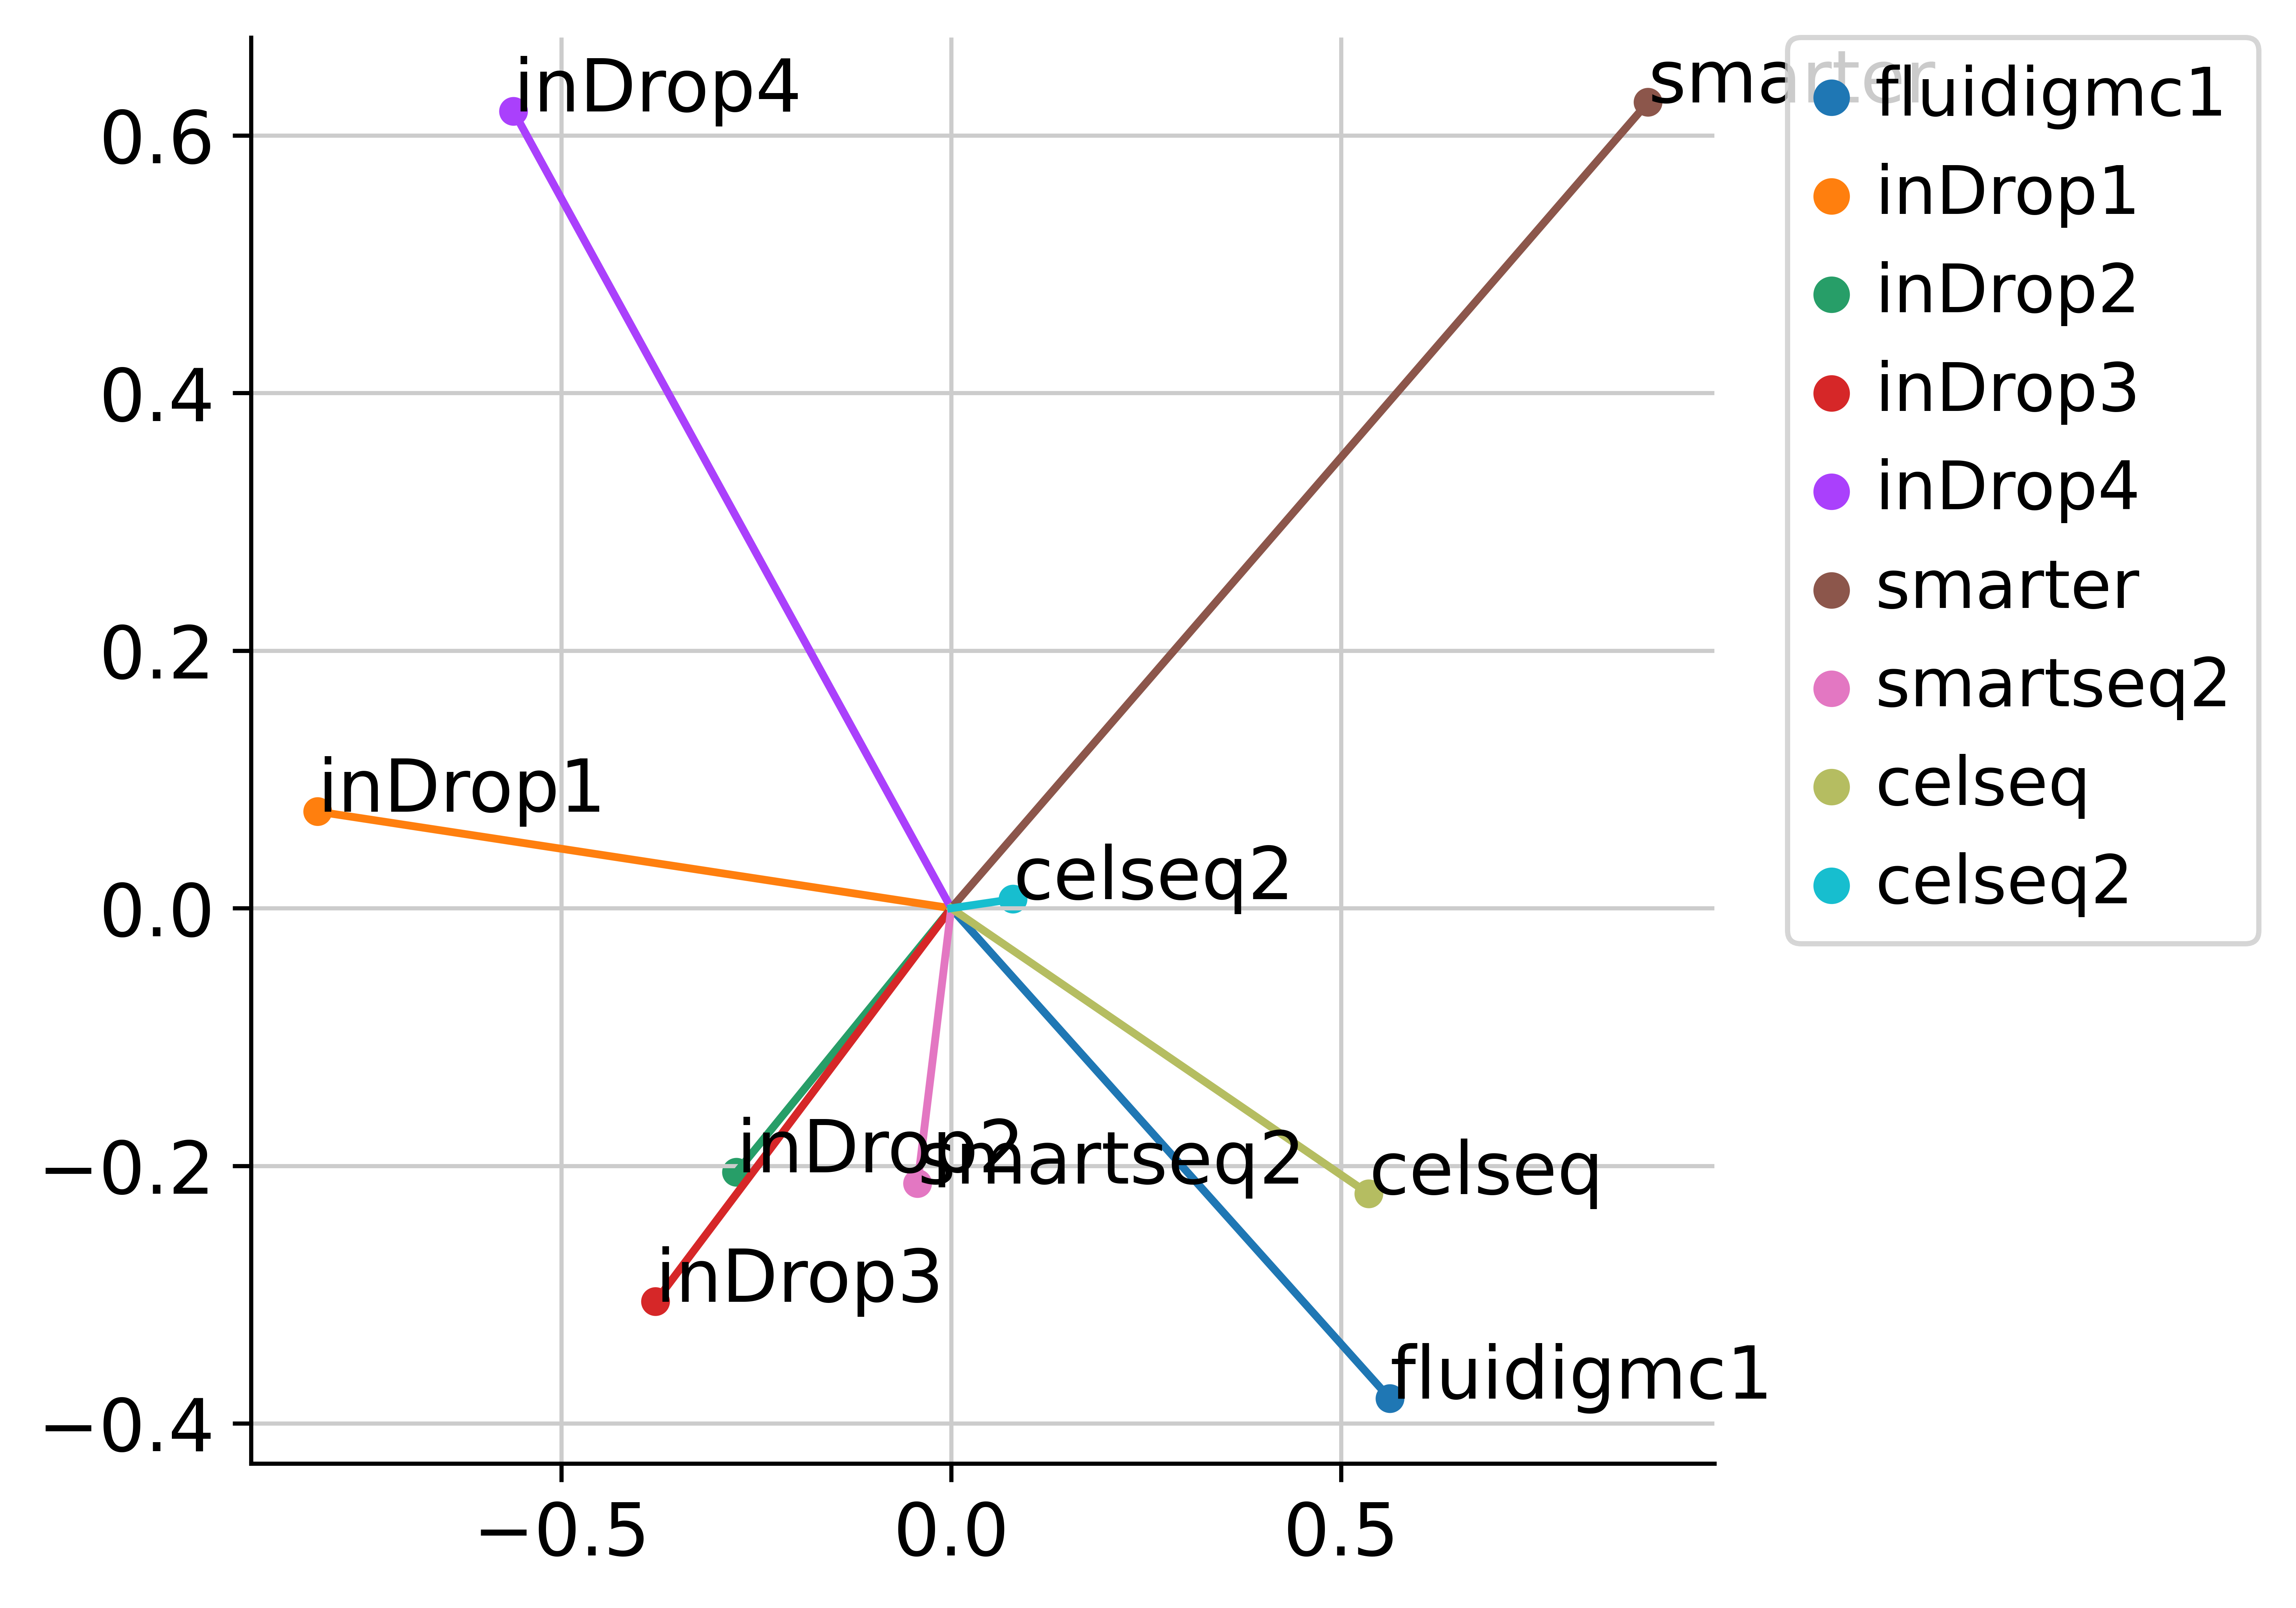

In [21]:
embedding = polie_query.model.embedding.weight.detach().cpu().numpy()
from sklearn.decomposition import KernelPCA
pca = KernelPCA(n_components=2, kernel='cosine')
emb_pca = pca.fit_transform(embedding)
conditions = polie_query.conditions_
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
sns.scatterplot(emb_pca[:, 0], emb_pca[:, 1], conditions, ax=ax)
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
for i, c in enumerate(conditions):
    ax.plot([0, emb_pca[i, 0]], [0, emb_pca[i, 1]])
    ax.text(emb_pca[i, 0], emb_pca[i, 1], c)
sns.despine()

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
sns.heatmap(
    cosine_similarity(embedding), 
    cmap='RdBu', 
    annot=True, 
    fmt='.2f',
    ax=ax,
    vmin=-1,
    vmax=1,
)
ax.set_xticklabels(polie_query.conditions_, rotation=90)
ax.set_yticklabels(polie_query.conditions_, rotation=0)

[Text(0, 0.5, 'fluidigmc1'),
 Text(0, 1.5, 'inDrop1'),
 Text(0, 2.5, 'inDrop2'),
 Text(0, 3.5, 'inDrop3'),
 Text(0, 4.5, 'inDrop4'),
 Text(0, 5.5, 'smarter'),
 Text(0, 6.5, 'smartseq2'),
 Text(0, 7.5, 'celseq'),
 Text(0, 8.5, 'celseq2')]

In [27]:
data_latent = polie_query.get_latent(
    adata.X, 
    adata.obs[condition_key].values
)
adata_latent = sc.AnnData(data_latent)
adata_latent.obs['batch'] = adata.obs[condition_key].tolist()
results_dict = polie_query.classify(
    adata.X, 
    adata.obs[condition_key], 
)
adata.obs['preds'] = results_dict['cell_type']['preds']
adata.obs['uncertainty'] = results_dict['cell_type']['probs']

adata_latent.obs = adata.obs
checks = np.array(len(adata) * ["incorrect"])
checks[adata.obs['preds'] == adata.obs[cell_type_key[0]]] = "correct"
adata_latent.obs['clf_correct'] = checks

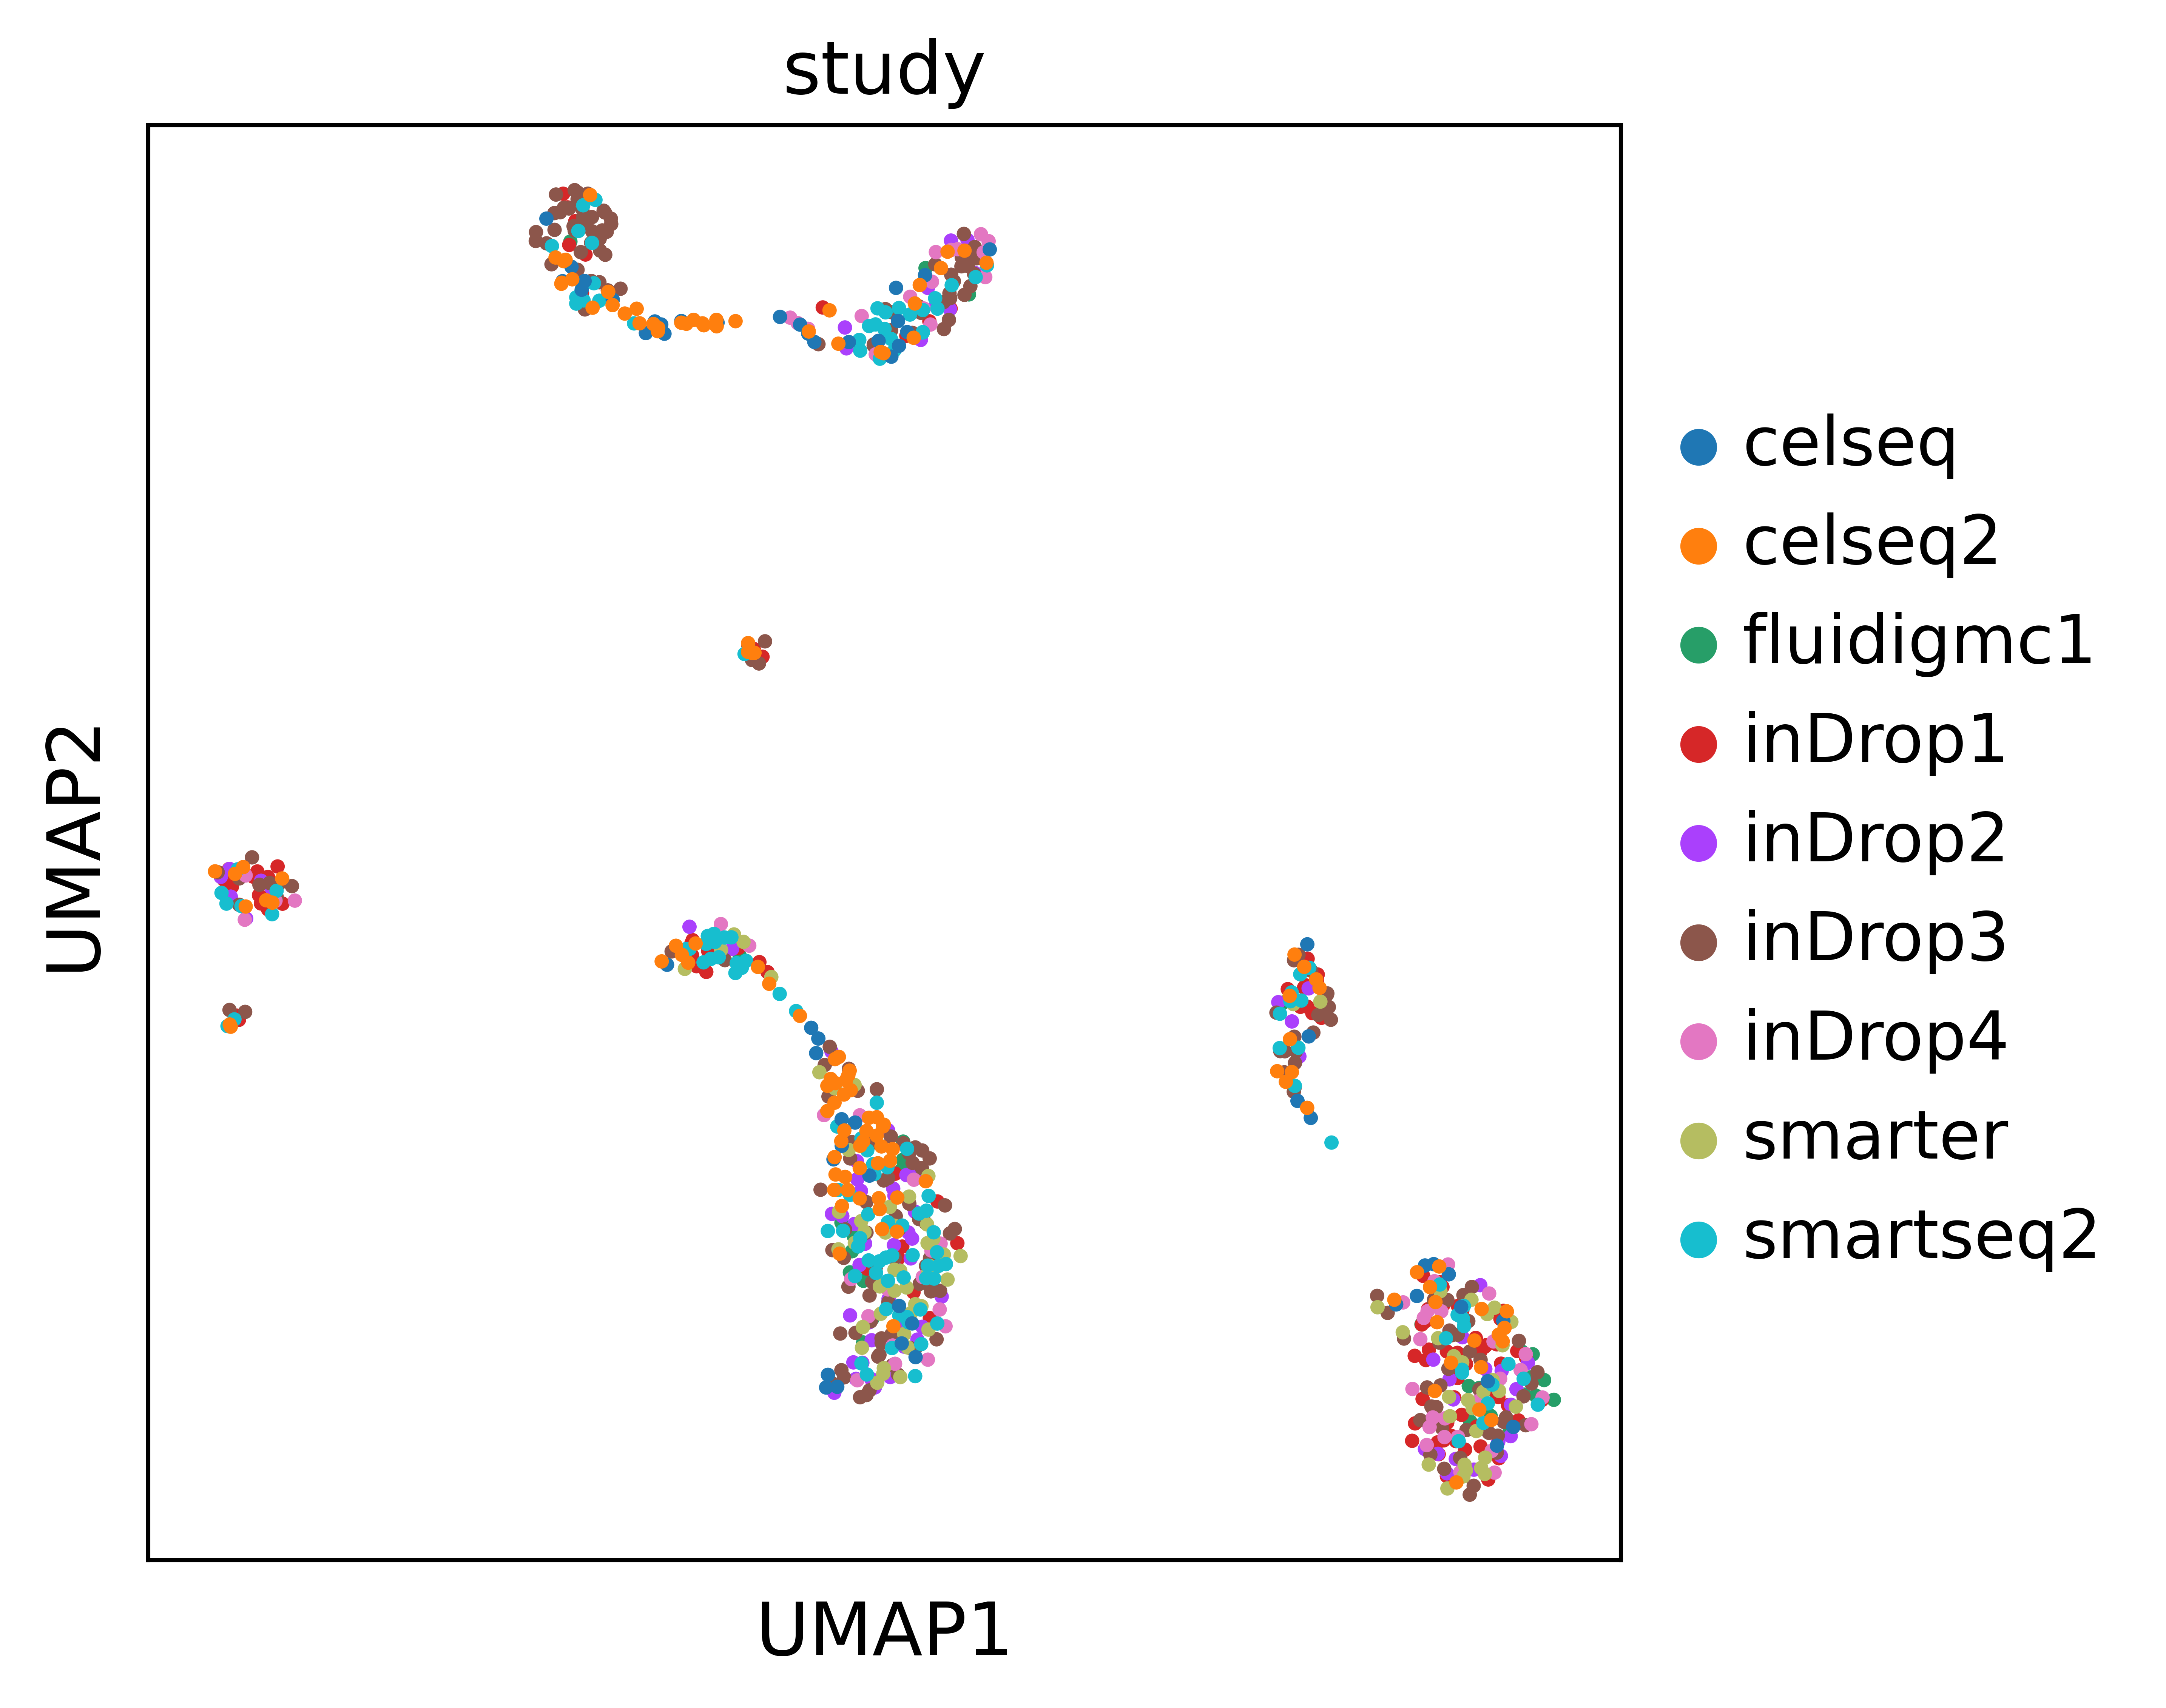

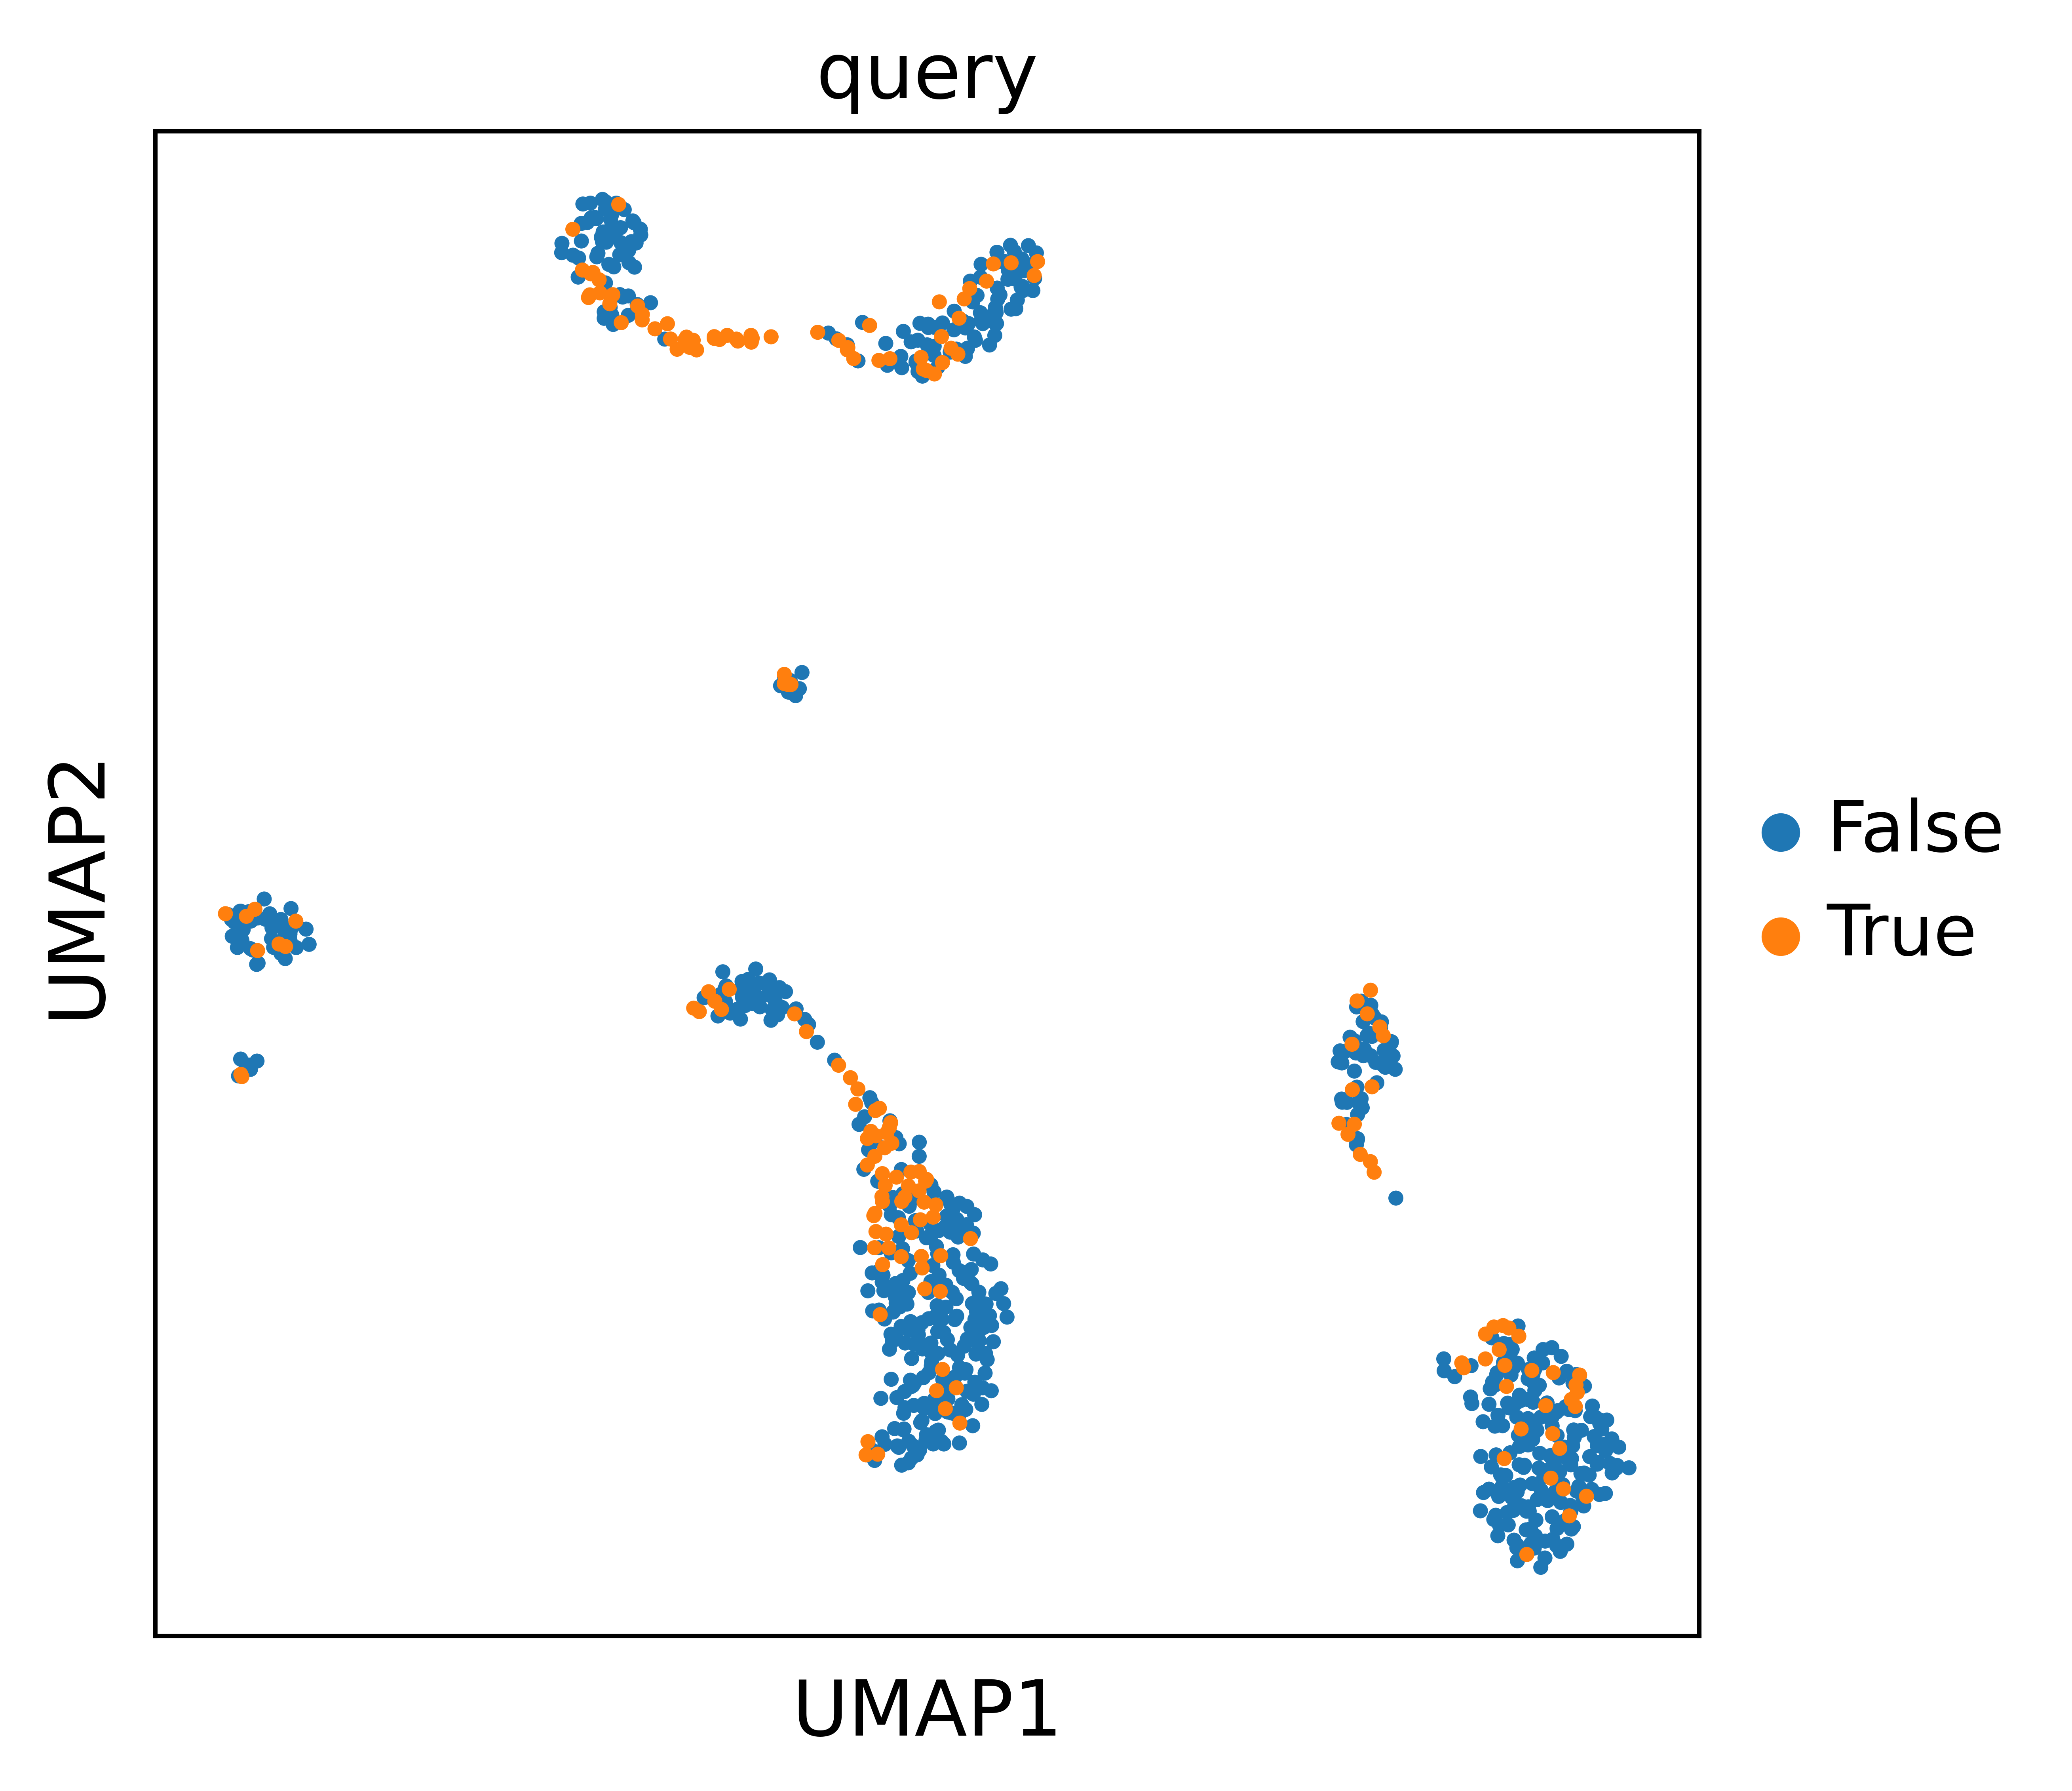

In [30]:
sc.pp.neighbors(adata_latent)
sc.tl.umap(adata_latent)
sc.pl.umap(adata_latent, color=condition_key, size=30)
sc.pl.umap(adata_latent, color='query', size=30)

/home/amir/projects/theis-lab/scarches/venv/lib/python3.10/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


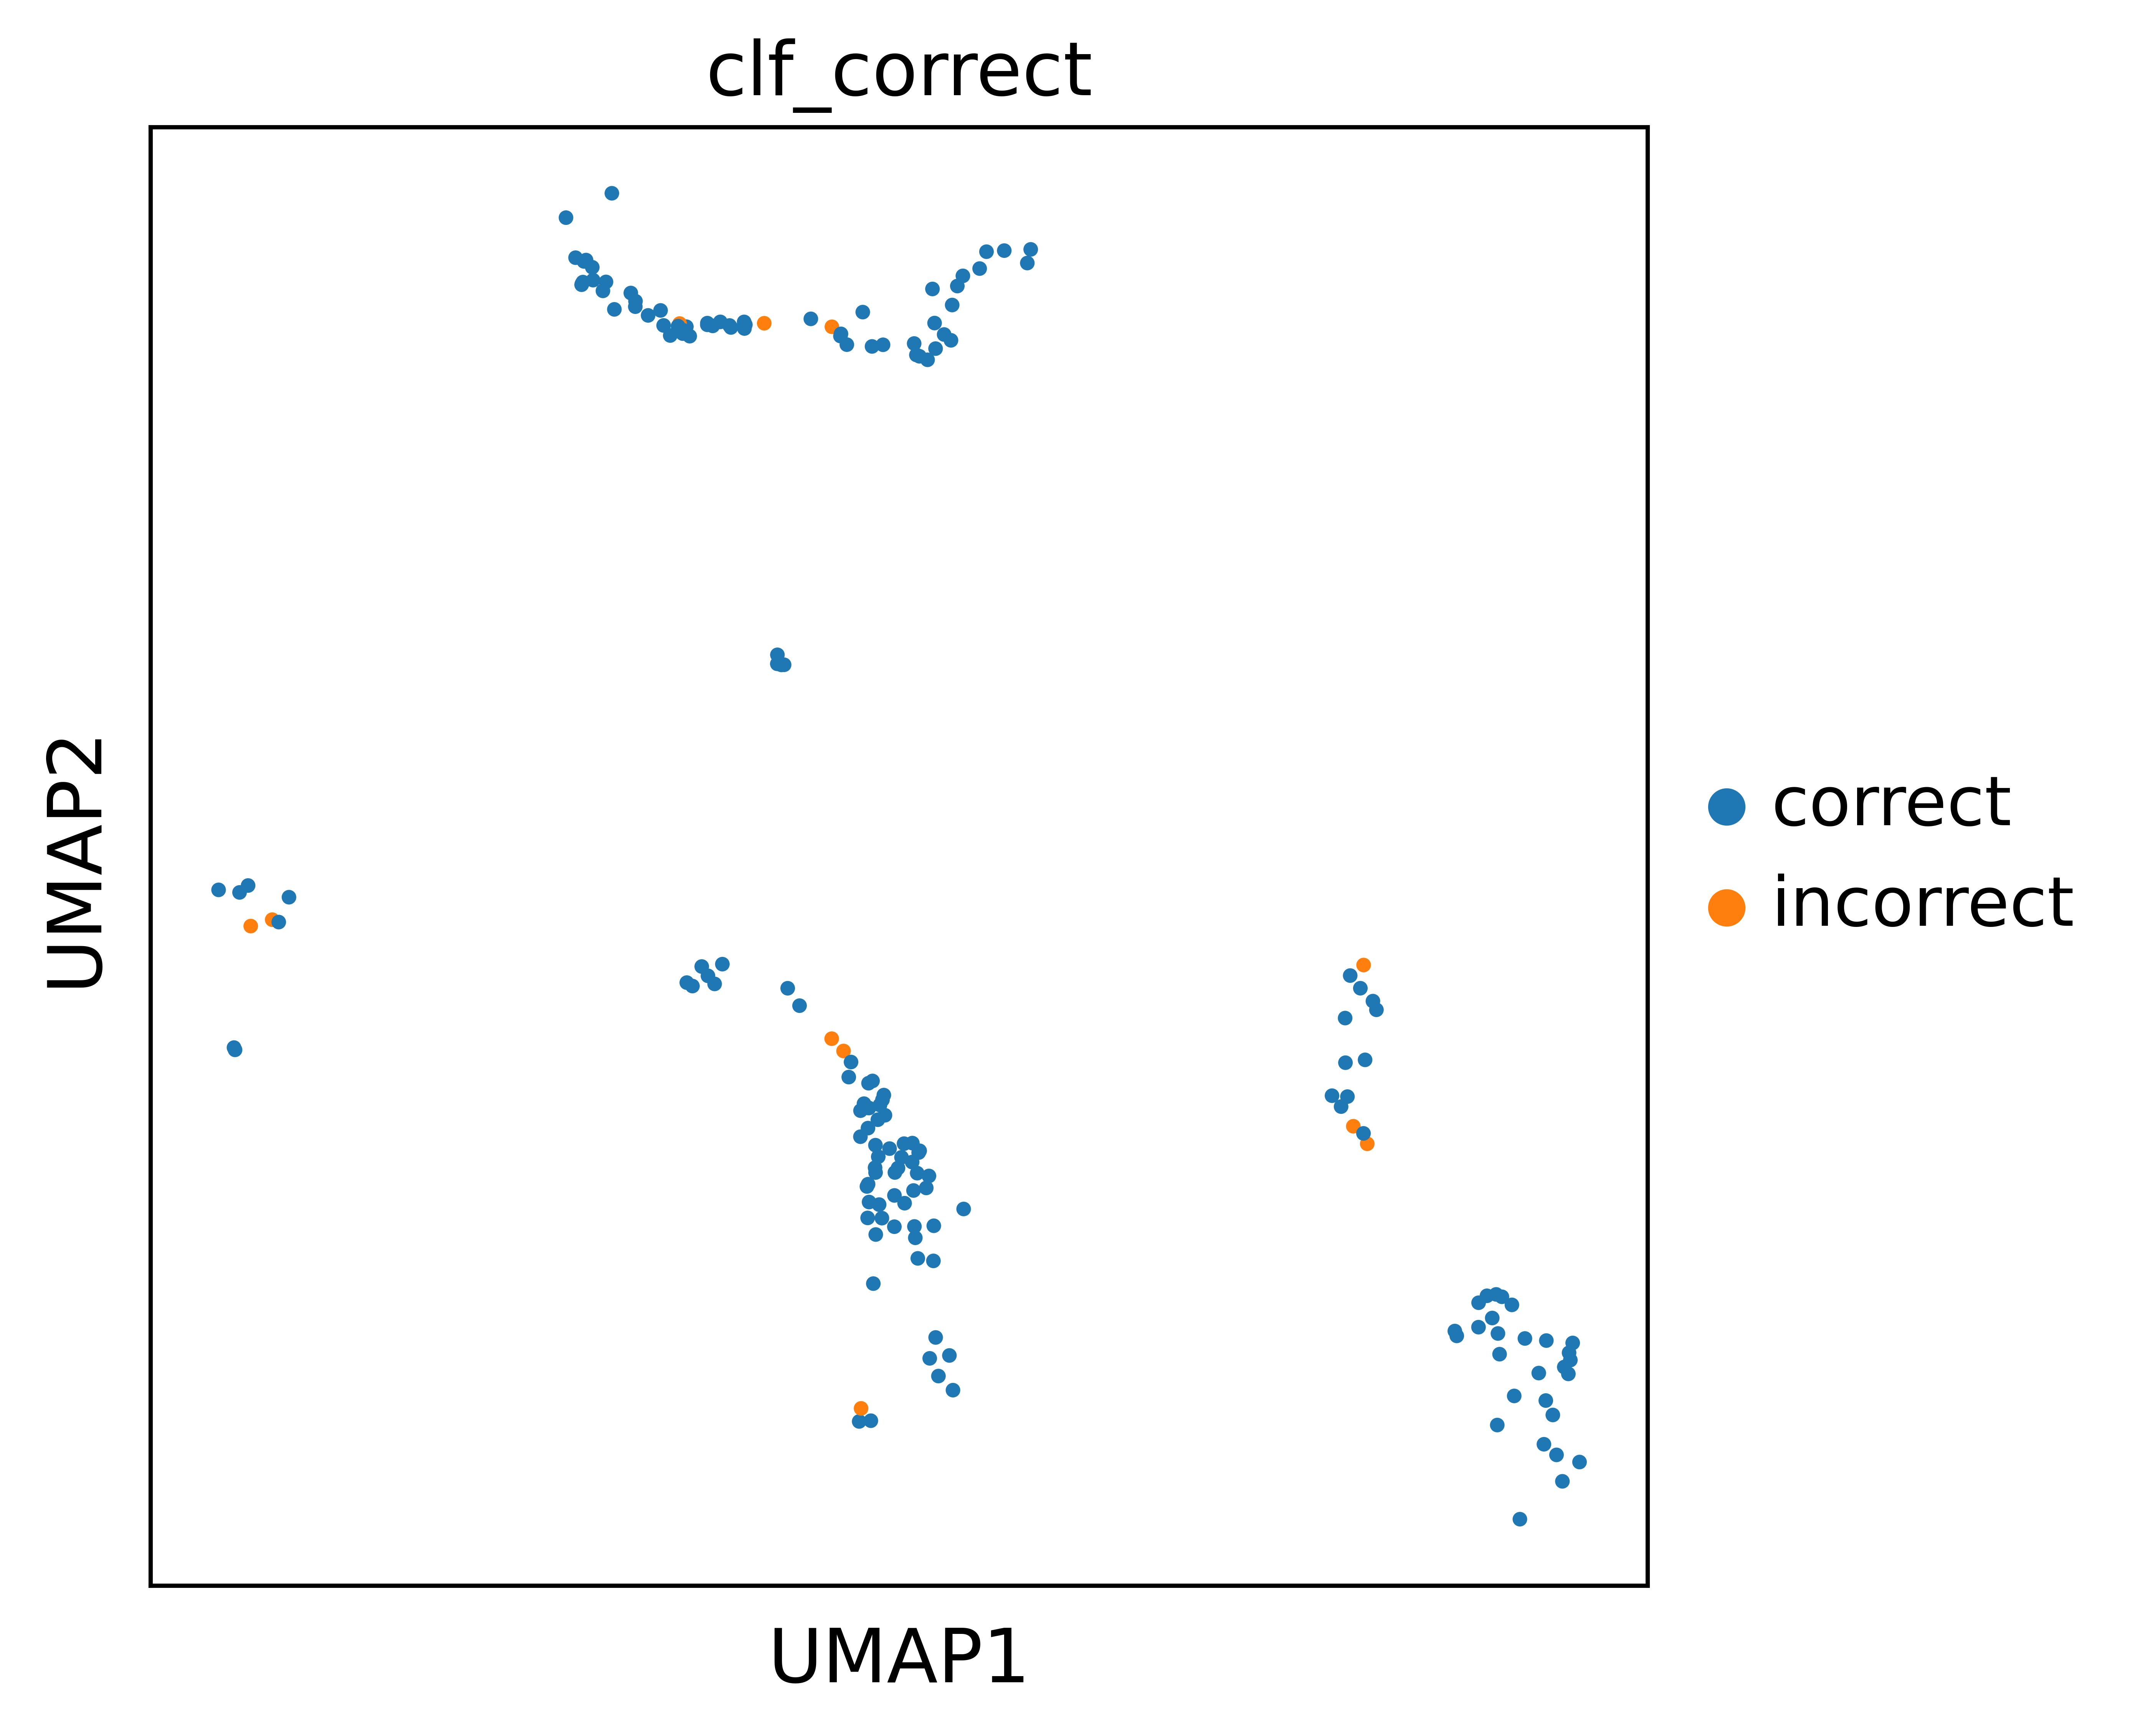

In [31]:
sc.pl.umap(adata_latent[adata_latent.obs.study.isin(query)], color='clf_correct', size=30)

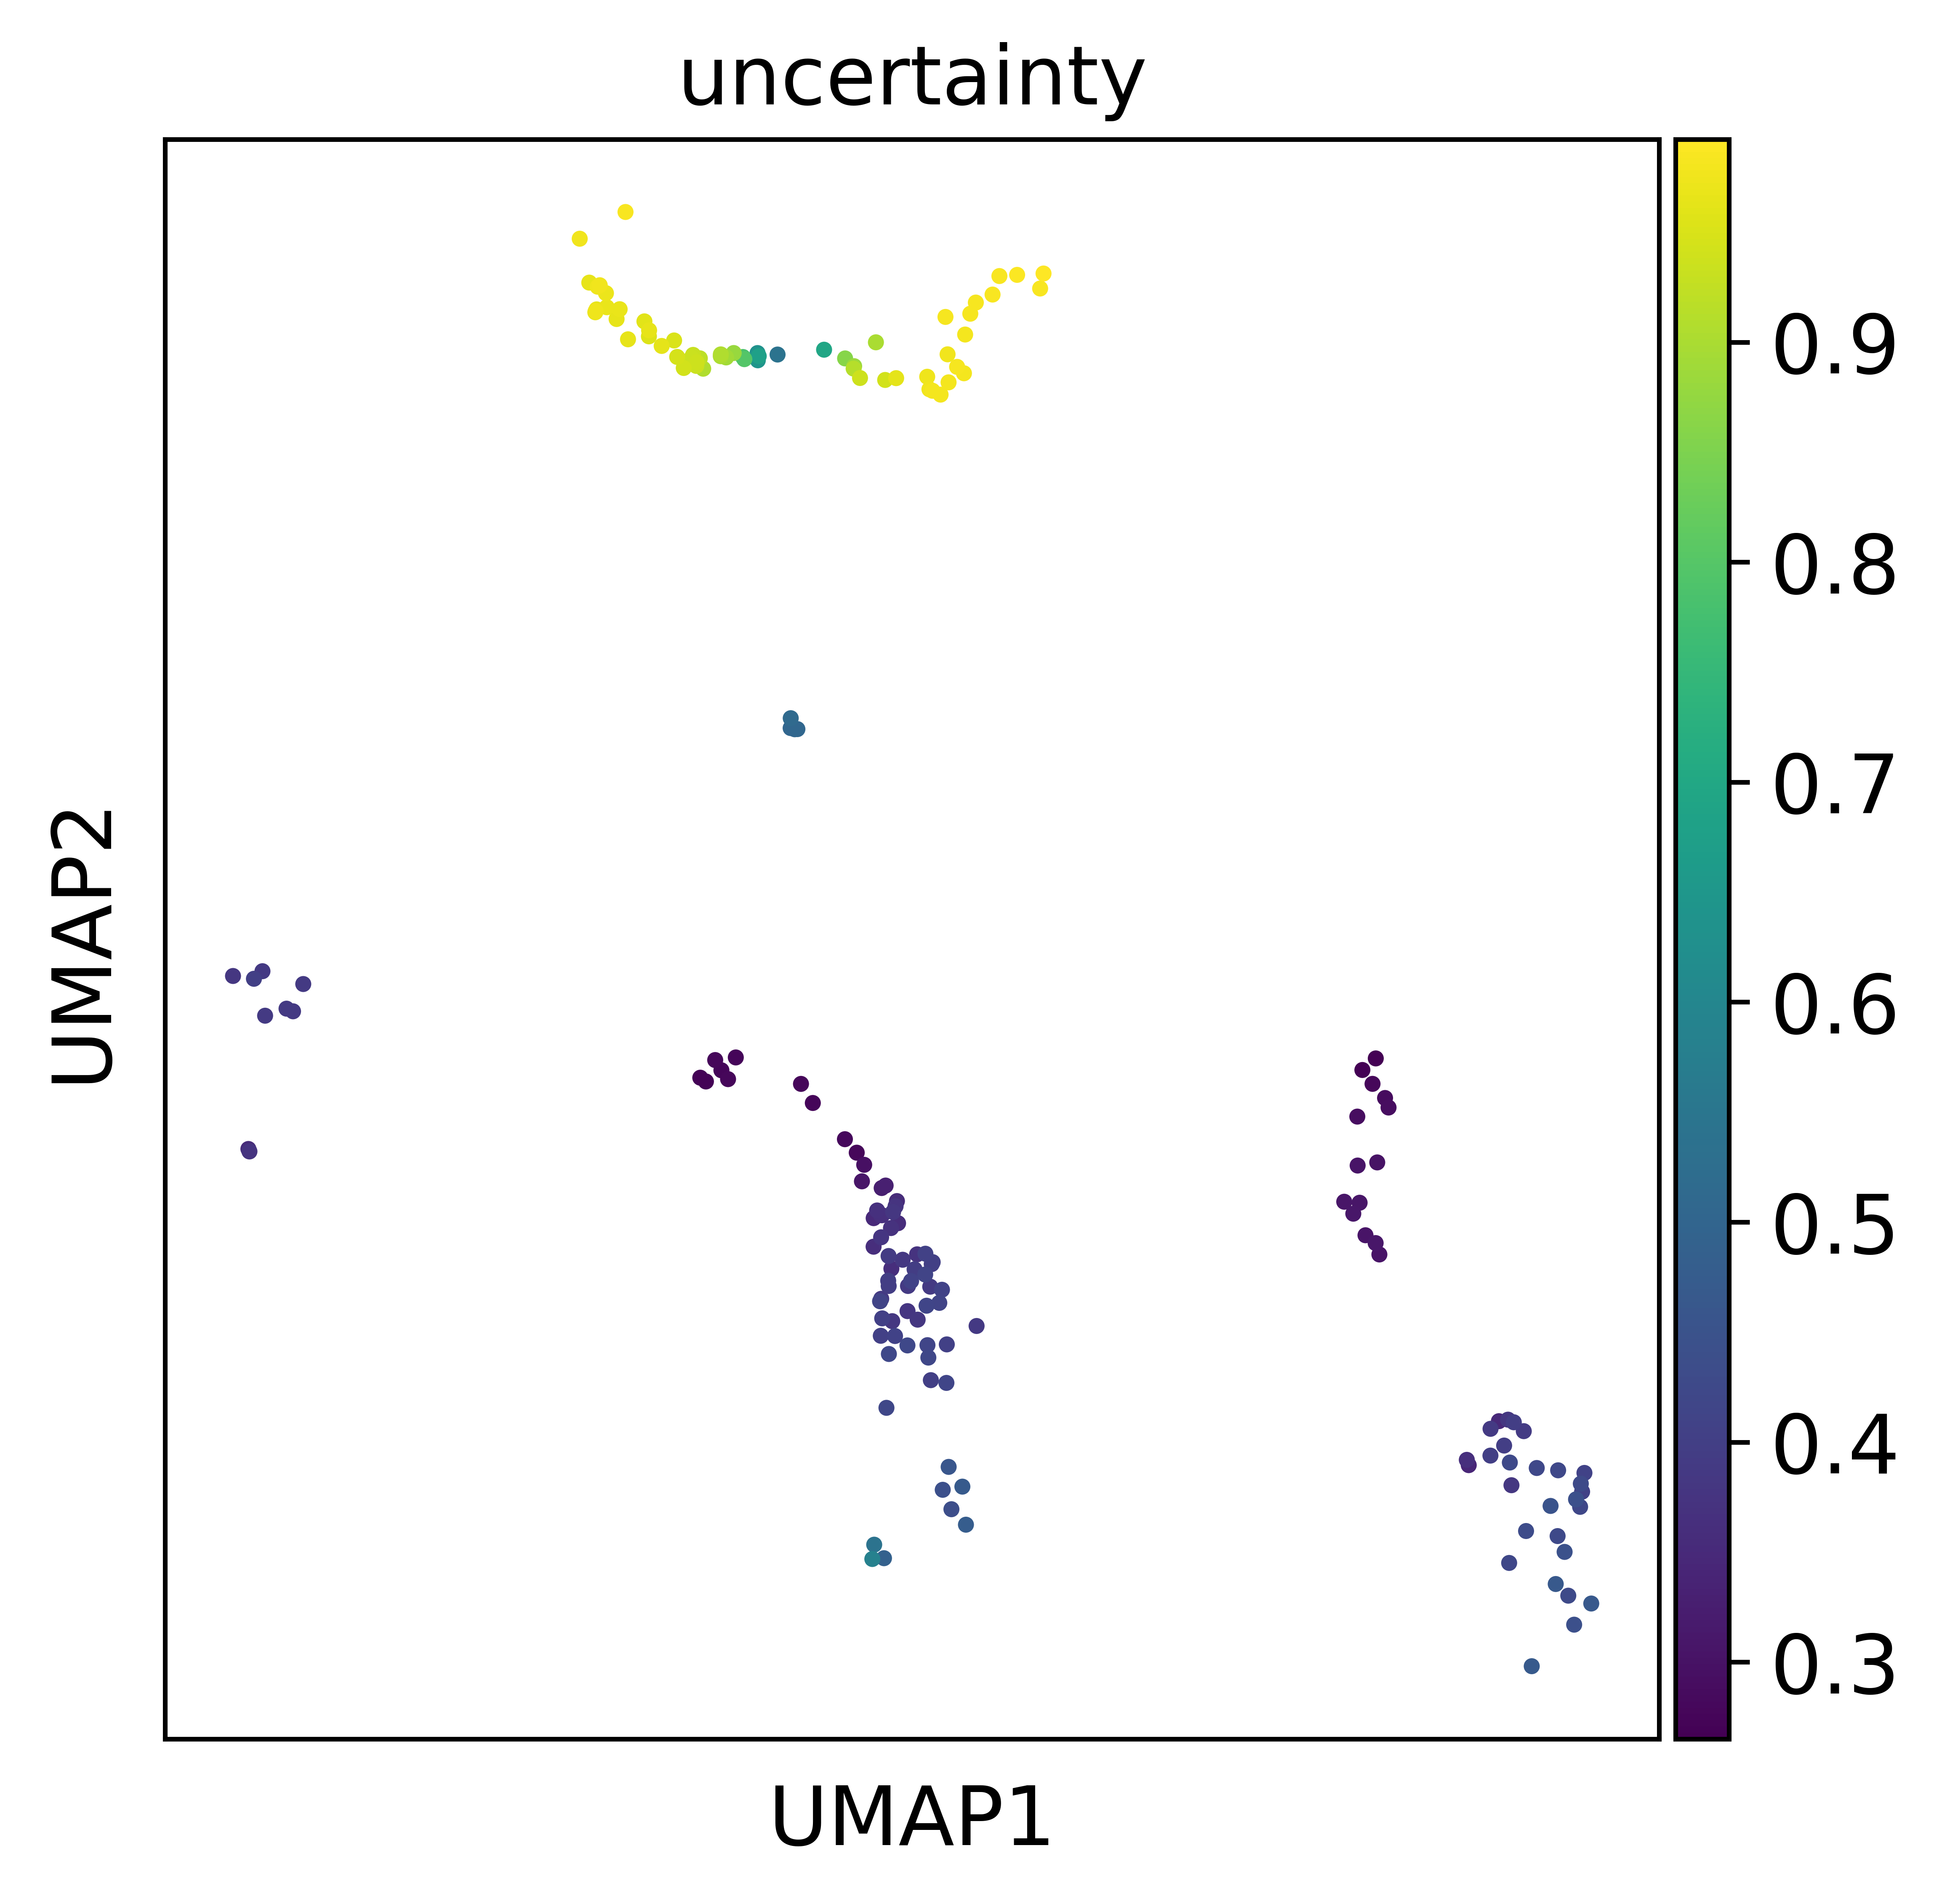

In [32]:
sc.pl.umap(adata_latent[adata_latent.obs.study.isin(query)], color='uncertainty', size=30)